***
created by **Farah Rabie** (f.rabie@hw.ac.uk)
***

#### Introduction

<p>This notebook focuses on classifying well log data to predict lithology from measured geophysical properties. Two machine learning algorithms are tested for this task: </p>
<ul>
    <li><code>K-Nearest Neighbours</code> - a method that classifies data points based on the majority class of their nearest neighbours.</li>
    <li><code>Random Forest</code> - a method that builds multiple decision trees and combines their predictions. </li>    
</ul>

Video tutorials covering this notebook are available here:  
- [Data Processing](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-1.mp4)  
- [K-Nearest Neighbours](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-2.mp4)  
- [Random Forest](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-3.mp4)

Let's get started! 

##### I$\,\,\,\,\,\,$Data Processing for Classification

To start, define the file paths for the training, validation, and test well log datasets.

In [ ]:
# List of wells:
#"/content/GeosciencePlusAI/Data/15_9-F-1 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-4.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-5.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-11 B.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-12.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-14.csv"
#"/content/GeosciencePlusAI/Data/15_9-F-15 C.csv"

train_well_data_path = [r".\Well Data\15_9-F-11 B.csv", 
                        r".\Well Data\15_9-F-12.csv",
                        r".\Well Data\15_9-F-5.csv"]

val_well_data_path = [r".\Well Data\15_9-F-15 C.csv", 
                      r".\Well Data\15_9-F-14.csv"]

test_well_data_path = [r".\Well Data\15_9-F-4.csv",
                       r".\Well Data\15_9-F-1 B.csv"]

Next, load the prepackaged data processing functions.  

This provides ready-made functions to visualise, clean, and scale the well log datasets.

In [ ]:
from Lib.ClassificationFunctions import DataProcessing
DataProcess = DataProcessing()

<p>Before processing the data, we visualise the lithology distribution across wells.  

This helps us understand the dataset structure and identify potential issues, such as class imbalances where some lithologies are under-represented.</p>

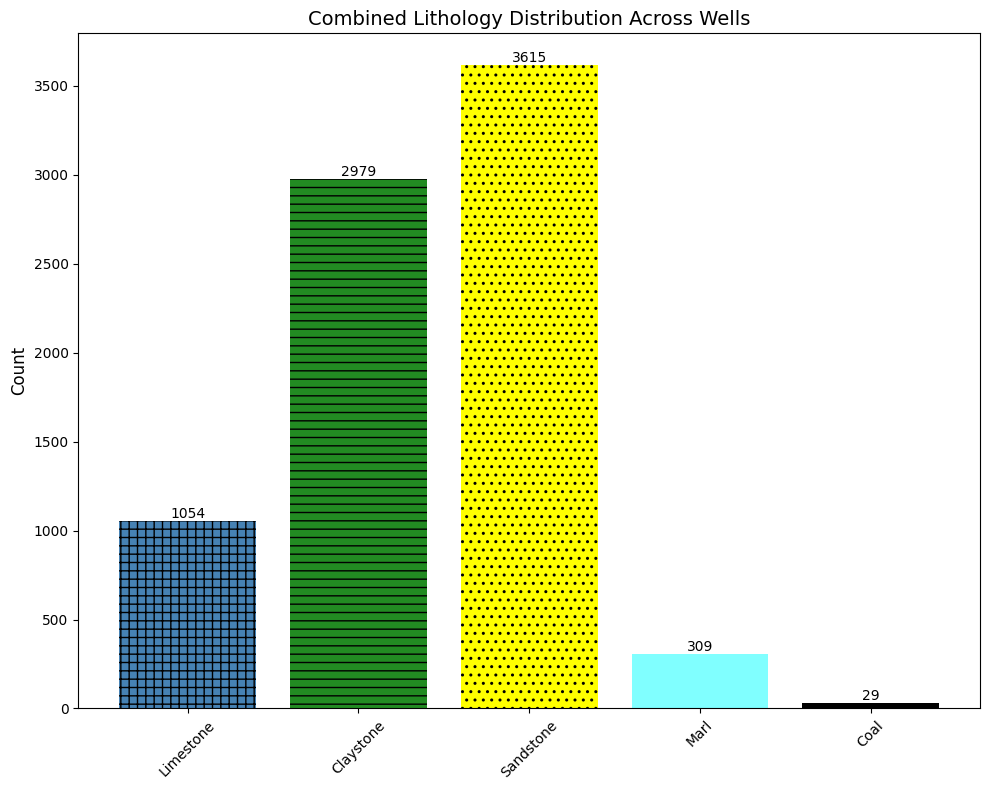

In [ ]:
DataProcess.visualise_lithology_distribution(train_well_data_path, display='count')
# The (display='both') option shows the lithology distribution as both counts and percentages.
# You can also choose 'count' or 'percentage' to display only one of these. By default, display is set to count.

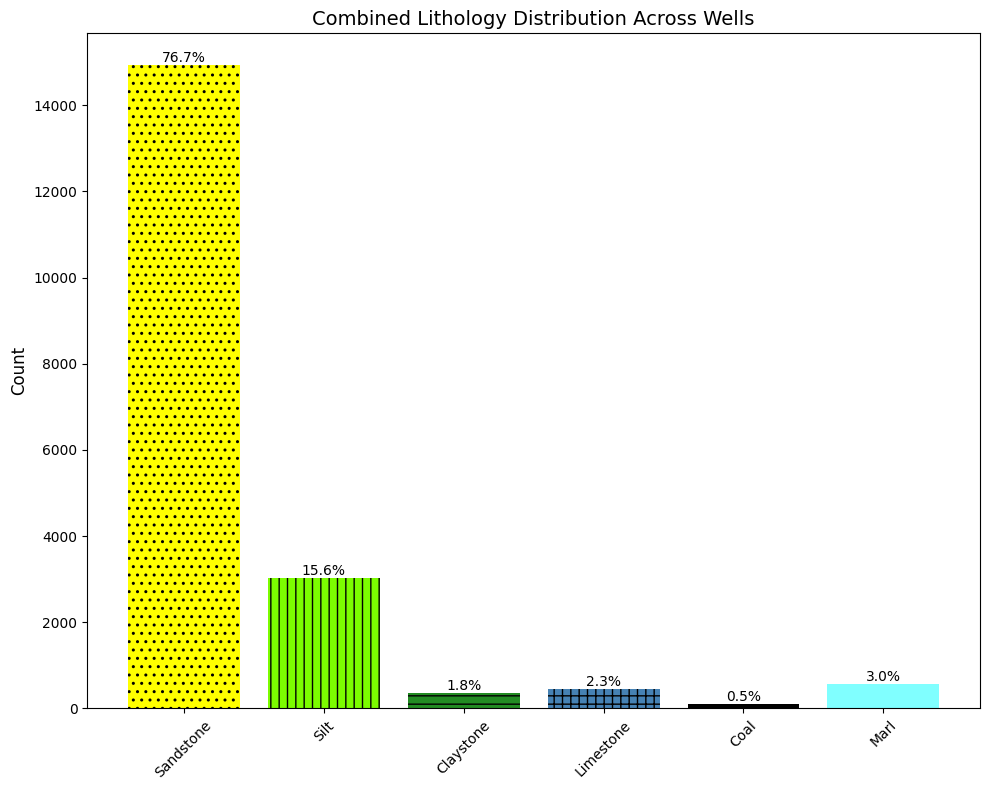

In [ ]:
DataProcess.visualise_lithology_distribution(val_well_data_path, display='percentage')

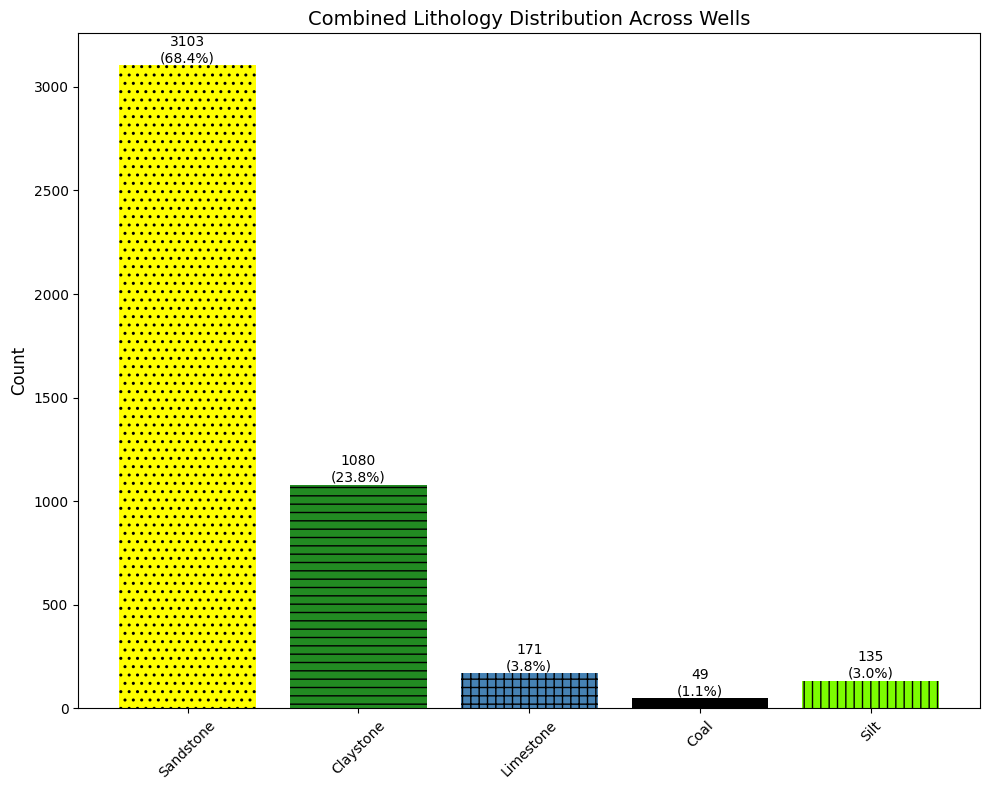

In [ ]:
DataProcess.visualise_lithology_distribution(test_well_data_path, display='both')

After visualising the lithology distribution and highlighting potential issues, the next step is to process the data.

Processing cleans and transforms the data into a format suitable for training machine learning algorithms.

The `process_well_data` function performs several key steps:

- Handles missing values.  
- Removes invalid points (values outside a specified range can be excluded).  
- Replaces original permeability and resistivity columns (`KLOGH` and `RT`) with their log-transformed versions.
- Computes scaling parameters using the training dataset.

First, select the relevant columns from the datasets for training, validation, and testing.

In [ ]:
selected_columns_train = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded
selected_columns_val = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded
selected_columns_test = ['DEPTH', 'BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded ('DEPTH' is included for visualisation purposes)

Next, process the training well data using the selected columns.  

In [ ]:
processed_train_well_data = DataProcess.process_well_data(train_well_data_path, selected_columns_train, method='standard', train_data=True, show_stats=True)

# The `method` parameter determines how the data will be scaled:
##   `standard` - transforms features to have a mean of 0 and a standard deviation of 1. Useful when the data roughly follows a Gaussian distribution.
##   `minmax_01` - scales features to the range [0, 1]. Useful when values need to be strictly positive or within a fixed range.
##   `minmax_11` - scales features to the range [-1, 1]. Often used in neural networks, especially when activation functions like tanh are applied.


Descriptive Statistics of Data:
               BVW          VSH           GR         NPHI         RHOB  \
count  7771.000000  7771.000000  7771.000000  7771.000000  7771.000000   
mean      0.072013     0.403292    56.941342     0.195790     2.418338   
std       0.055299     0.229133    30.834602     0.061295     0.153285   
min       0.000000     0.000000     5.616400     0.000000     1.429500   
25%       0.034500     0.219250    31.924601     0.159650     2.277100   
50%       0.063500     0.360700    52.284599     0.193400     2.450200   
75%       0.099900     0.551700    76.376602     0.229900     2.540100   
max       1.000000     1.000000   149.294403     0.597300     3.039200   

         log_KLOGH       log_RT  
count  7771.000000  7771.000000  
mean      1.778689     1.865283  
std       2.275160     1.443281  
min       0.000000     0.107598  
25%       0.001599     0.944334  
50%       0.426248     1.220446  
75%       3.275891     2.378550  
max      11.186140     8.517

Using the same function, process the validation and test data (using selected columns).

In [ ]:
processed_val_well_data = DataProcess.process_well_data(val_well_data_path, selected_columns_val, val_data=True, show_stats=False)

In [ ]:
processed_test_well_data = DataProcess.process_well_data(test_well_data_path, selected_columns_test, show_stats=False)

<p> Now, we scale the three datasets. When all numerical features are on the same scale, no single feature dominates due to its scale.
<p> To apply a specific scaling method, we can pass it as a parameter when computing the scaling parameters. For example, to standardise, we include <code>method='standard'</code> in <code>process_well_data</code>.</p>

In [ ]:
scaled_train_well_data = DataProcess.scale_dataframe(processed_train_well_data, show_stats=True)
# with show_stats = True >> allows us to confirm that the standardisation parameters are kept constant.


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.07201299535040535, 'std': 0.055299364074613964}
VSH: {'mean': 0.40329186564393255, 'std': 0.22913256724203046}
GR: {'mean': 56.94134153439918, 'std': 30.834602294468088}
NPHI: {'mean': 0.19578956202213355, 'std': 0.06129457716850229}
RHOB: {'mean': 2.418337716321323, 'std': 0.15328525418370356}
log_KLOGH: {'mean': 1.7786886013088152, 'std': 2.275160122124349}
log_RT: {'mean': 1.8652829049298525, 'std': 1.4432806944125387}


<p>We can then scale the validation dataset.</p>

In [ ]:
scaled_val_well_data = DataProcess.scale_dataframe(processed_val_well_data, show_stats=True)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.07201299535040535, 'std': 0.055299364074613964}
VSH: {'mean': 0.40329186564393255, 'std': 0.22913256724203046}
GR: {'mean': 56.94134153439918, 'std': 30.834602294468088}
NPHI: {'mean': 0.19578956202213355, 'std': 0.06129457716850229}
RHOB: {'mean': 2.418337716321323, 'std': 0.15328525418370356}
log_KLOGH: {'mean': 1.7786886013088152, 'std': 2.275160122124349}
log_RT: {'mean': 1.8652829049298525, 'std': 1.4432806944125387}


<p>And finally, we scale the test dataset.</p>

In [ ]:
scaled_test_well_data = [] # each well has its data stored in a separate DataFrame
for df in processed_test_well_data:
    scaled_df = DataProcess.scale_dataframe(df, show_stats=True)
    scaled_test_well_data.append(scaled_df)


Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.07201299535040535, 'std': 0.055299364074613964}
VSH: {'mean': 0.40329186564393255, 'std': 0.22913256724203046}
GR: {'mean': 56.94134153439918, 'std': 30.834602294468088}
NPHI: {'mean': 0.19578956202213355, 'std': 0.06129457716850229}
RHOB: {'mean': 2.418337716321323, 'std': 0.15328525418370356}
log_KLOGH: {'mean': 1.7786886013088152, 'std': 2.275160122124349}
log_RT: {'mean': 1.8652829049298525, 'std': 1.4432806944125387}

Scaling Method: standard
Scaling Parameters:
BVW: {'mean': 0.07201299535040535, 'std': 0.055299364074613964}
VSH: {'mean': 0.40329186564393255, 'std': 0.22913256724203046}
GR: {'mean': 56.94134153439918, 'std': 30.834602294468088}
NPHI: {'mean': 0.19578956202213355, 'std': 0.06129457716850229}
RHOB: {'mean': 2.418337716321323, 'std': 0.15328525418370356}
log_KLOGH: {'mean': 1.7786886013088152, 'std': 2.275160122124349}
log_RT: {'mean': 1.8652829049298525, 'std': 1.4432806944125387}


Once data processing is complete, we can visualise data distributions before and after processing for comparison.

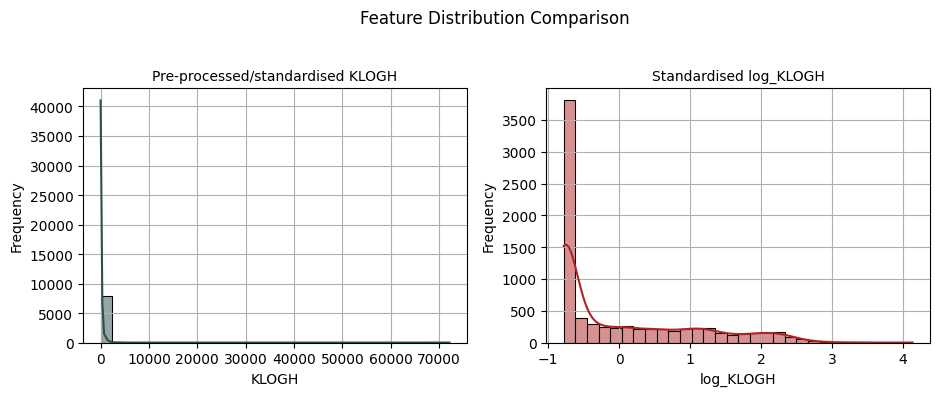

In [ ]:
import pandas as pd
train_well_data = pd.concat((pd.read_csv(path) for path in train_well_data_path), ignore_index=True)
DataProcess.compare_distributions(train_well_data, scaled_train_well_data, 'KLOGH', 'log_KLOGH', title="Feature Distribution Comparison") # can plot processed_train_well_data and scaled_train_well_data to compare too.

##### II$\,\,\,\,\,\,$K-Nearest Neighbours for Classification

<p>K-Nearest Neighbours (KNN) is a supervised machine learning algorithm used for classification and regression. It classifies a data point based on the majority class of its closest <em>k</em> neighbours in the feature space.

In this notebook, we apply KNN to classify lithology types from well log data. Given a new data point, KNN will predict its lithology based on similar known samples. This approach is useful when we have well-separated clusters of lithology types.</p>



In [ ]:
# KNNClassification >> module to train a KNN classifier on labelled well log data, predict lithology labels for query data points, and evaluate accuracy of trained model
from Lib.ClassificationFunctions import KNNClassification
KNNClassifier = KNNClassification()

<p>We start off with determining <em>k</em>, the number of neighbours considered for classification. Using the <code>tune_knn_k()</code> function, we can test different <em>k</em> values (from 1 to k_max) on the standardised training and validation well log data. The best <em>k</em> value is one that maximises accuracy.

First, select the feature columns and the target column.

In [ ]:
feature_columns = ['BVW', 'log_KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'log_RT']
target_column = 'LITHOLOGY'

And then, run <code>tune_knn_k()</code>.

Accuracy for k=1: 0.6582
Accuracy for k=2: 0.6582
Accuracy for k=3: 0.6705
Accuracy for k=4: 0.6727
Accuracy for k=5: 0.6792
Accuracy for k=6: 0.6817
Accuracy for k=7: 0.6830
Accuracy for k=8: 0.6859
Accuracy for k=9: 0.6871
Accuracy for k=10: 0.6885
Accuracy for k=11: 0.6902
Accuracy for k=12: 0.6911
Accuracy for k=13: 0.6908
Accuracy for k=14: 0.6917
Accuracy for k=15: 0.6929
Accuracy for k=16: 0.6944
Accuracy for k=17: 0.6936
Accuracy for k=18: 0.6945
Accuracy for k=19: 0.6943
Accuracy for k=20: 0.6944
Accuracy for k=21: 0.6937
Accuracy for k=22: 0.6942
Accuracy for k=23: 0.6935
Accuracy for k=24: 0.6934
Accuracy for k=25: 0.6932
Accuracy for k=26: 0.6932
Accuracy for k=27: 0.6935
Accuracy for k=28: 0.6937
Accuracy for k=29: 0.6933
Accuracy for k=30: 0.6932

Best k: 18 with accuracy: 0.6945


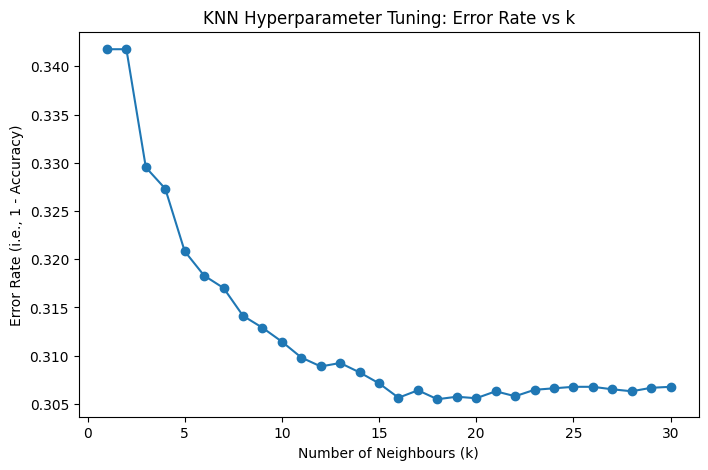

In [ ]:
best_k, best_knn_model, best_accuracy = KNNClassifier.tune_knn_k(scaled_train_well_data,
                                                                 scaled_val_well_data,
                                                                 feature_columns,
                                                                 target_column,
                                                                 k_max=30,
                                                                 weights='distance', # another option: 'uniform'
                                                                 # weights = 'uniform' assigns uniform weights to each neighbour.
                                                                 # for weights = 'distance', closer neighbours have more influence on the prediction, while farther ones have less influence.
                                                                 metric='euclidean') # another option: 'manhattan'

<p>Now, we can train the KNN classifier using <code>train_knn()</code>. It takes as input the scaled training data, the feature and target columns, and the optimal <em>k</em> value.

In [ ]:
trained_KNN = KNNClassifier.train_knn(scaled_train_well_data, feature_columns, target_column, k=7)

We can use `test_knn()` function to apply the trained KNN model to the scaled validation data to predict lithology labels.

In [ ]:
processed_val_singles_well_data = DataProcess.process_well_data(val_well_data_path, selected_columns_test, show_stats=False)

scaled_val_singles_well_data = [] # each well has its data stored in a separate DataFrame
for df in processed_val_singles_well_data:
    scaled_df = DataProcess.scale_dataframe(df, show_stats=False)
    scaled_val_singles_well_data.append(scaled_df)

accuracy_val_KNN, val_KNN_predicted_lithology = KNNClassifier.test_knn(trained_KNN, scaled_val_singles_well_data[0], feature_columns, target_column)

Accuracy of KNN when tested is 0.6339041588717801


<p>We use <code>plot_lithology_comparison()</code> To visually compare the predictions of the trained KNN with the actual lithology.</p>

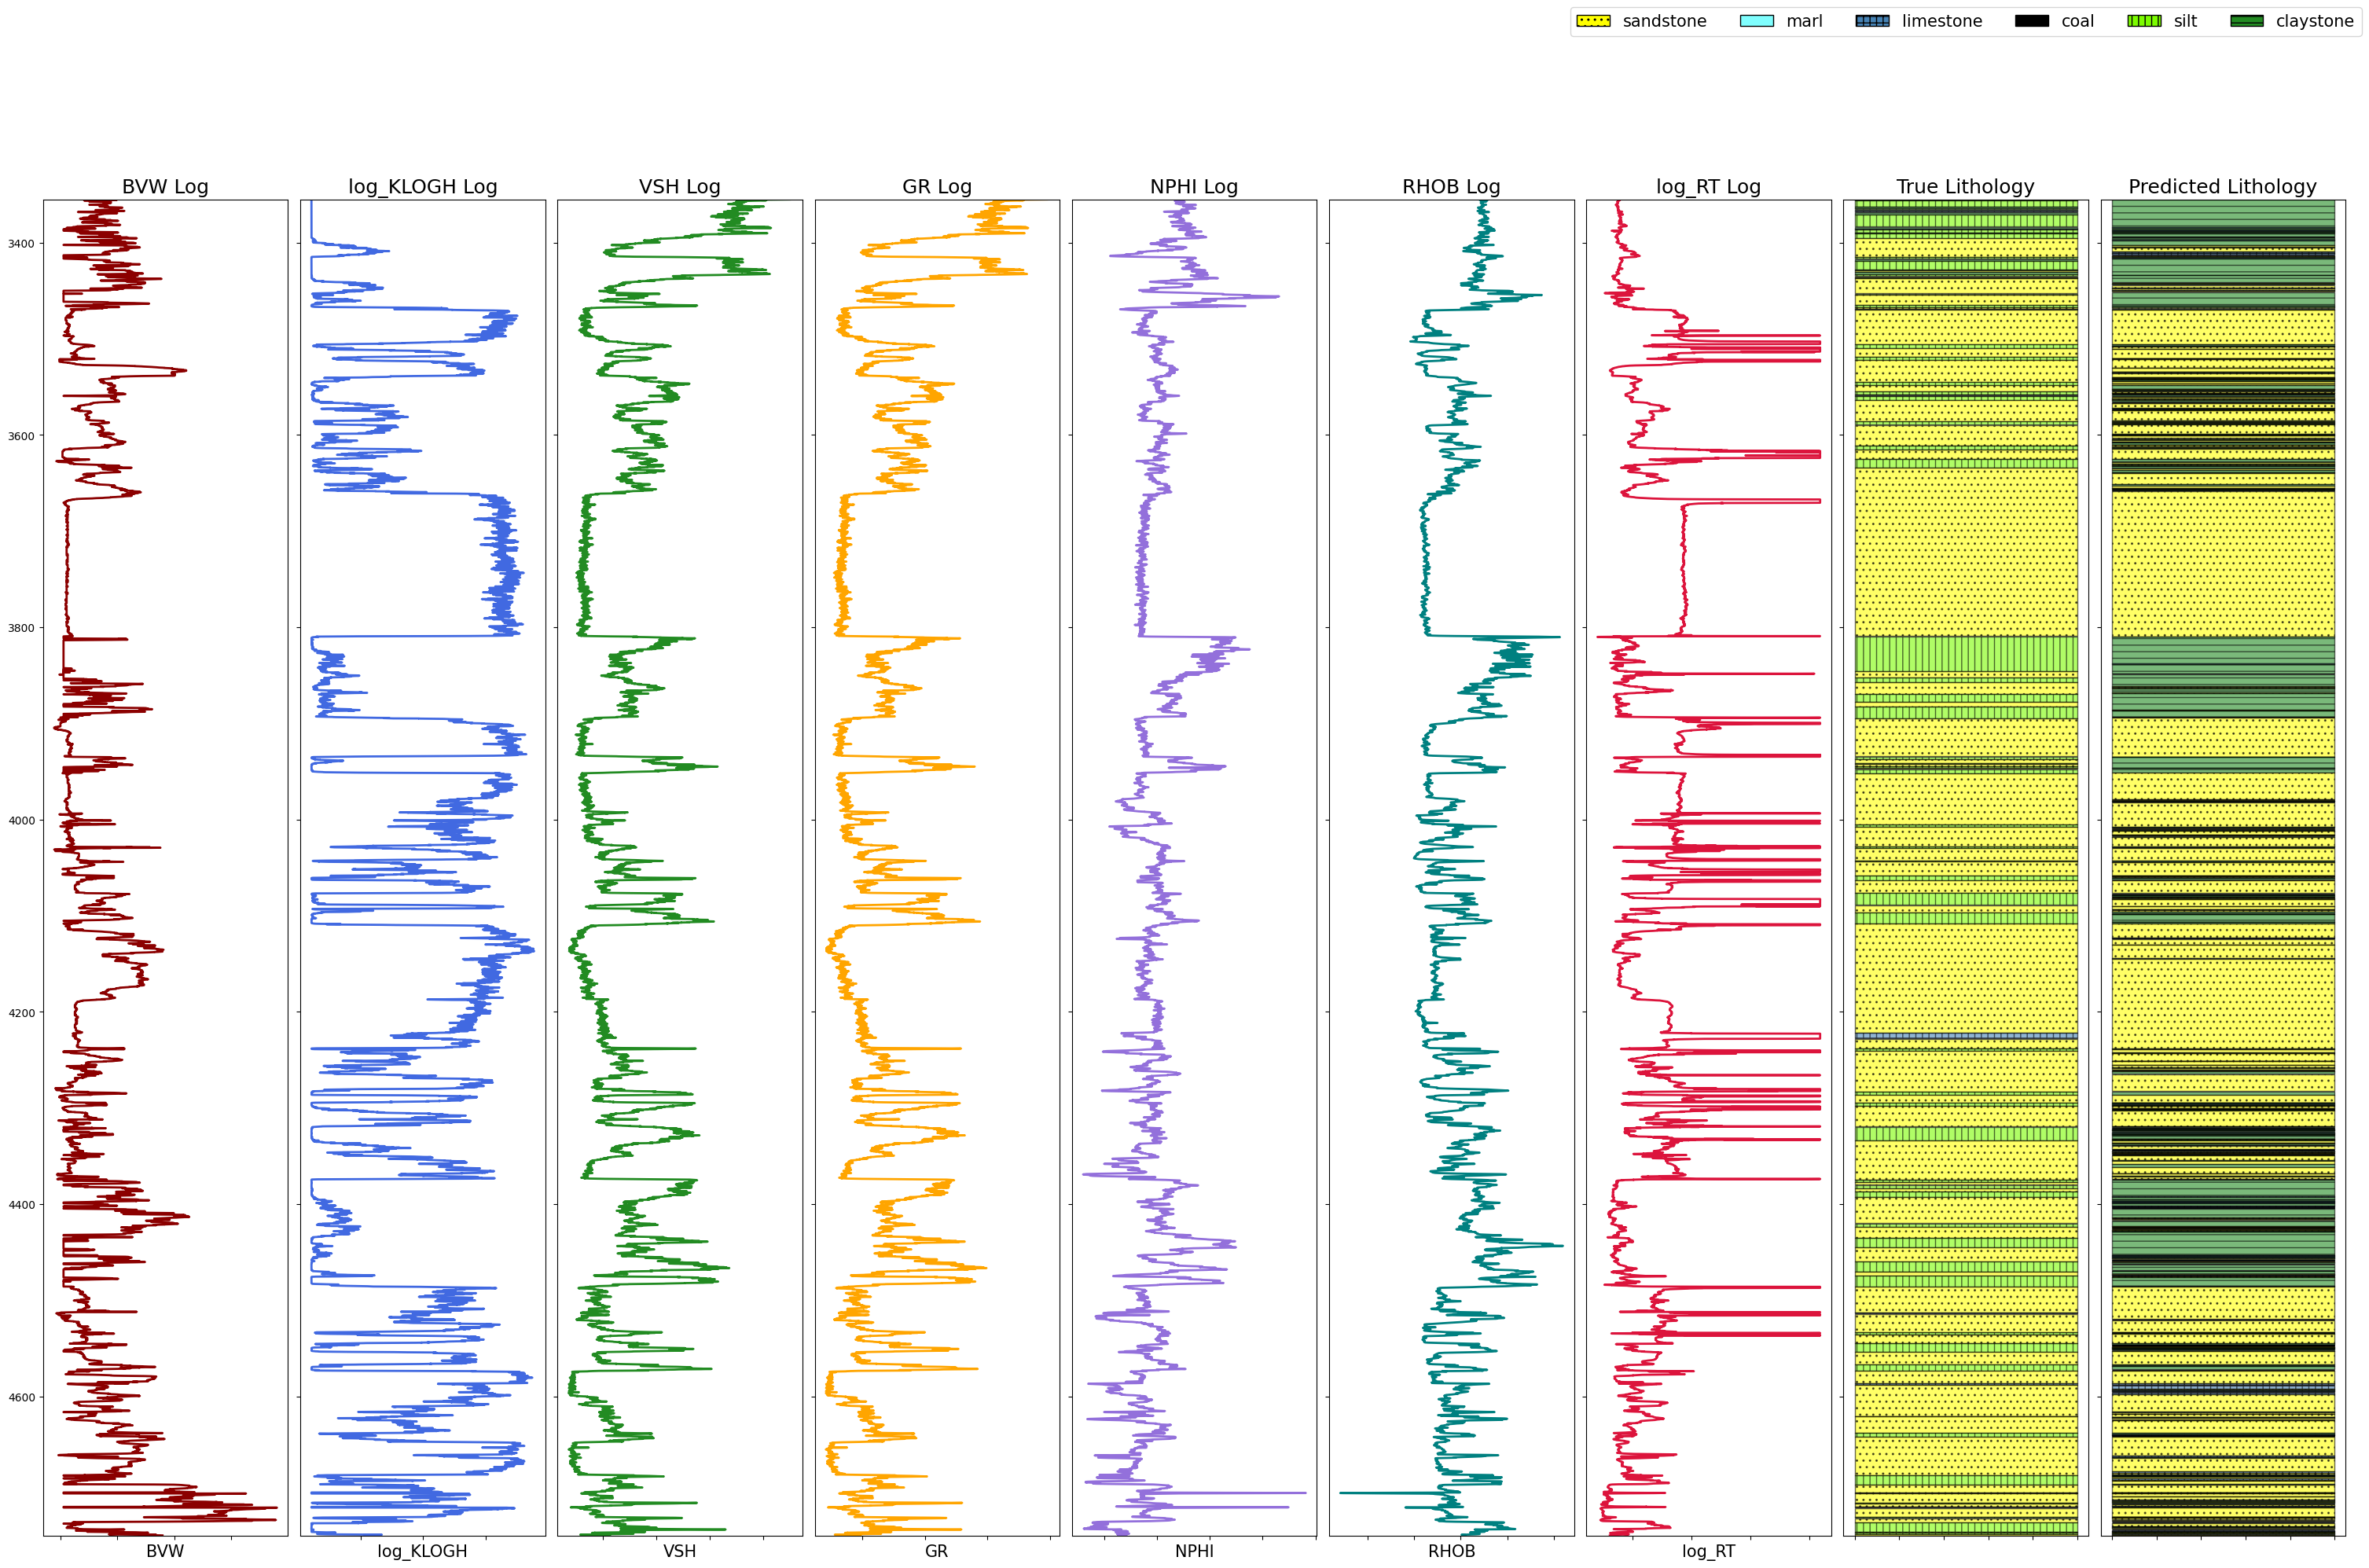

In [ ]:
KNNClassifier.plot_lithology_comparison(scaled_val_singles_well_data[0], val_KNN_predicted_lithology, use_hatch=True, log_columns=feature_columns)

Using `test_knn()`, we can also apply the trained KNN model to the scaled test data to predict lithology labels.

In [ ]:
accuracy_test_KNN, test_KNN_predicted_lithology = KNNClassifier.test_knn(trained_KNN, scaled_test_well_data[0], feature_columns, target_column)

Accuracy of KNN when tested is 0.7680608365019012


<p>And then, we use <code>plot_lithology_comparison()</code> to create a depth profile plot with side-by-side comparisons of the true lithology from the test dataset and the predicted lithology from the trained KNN.</p>

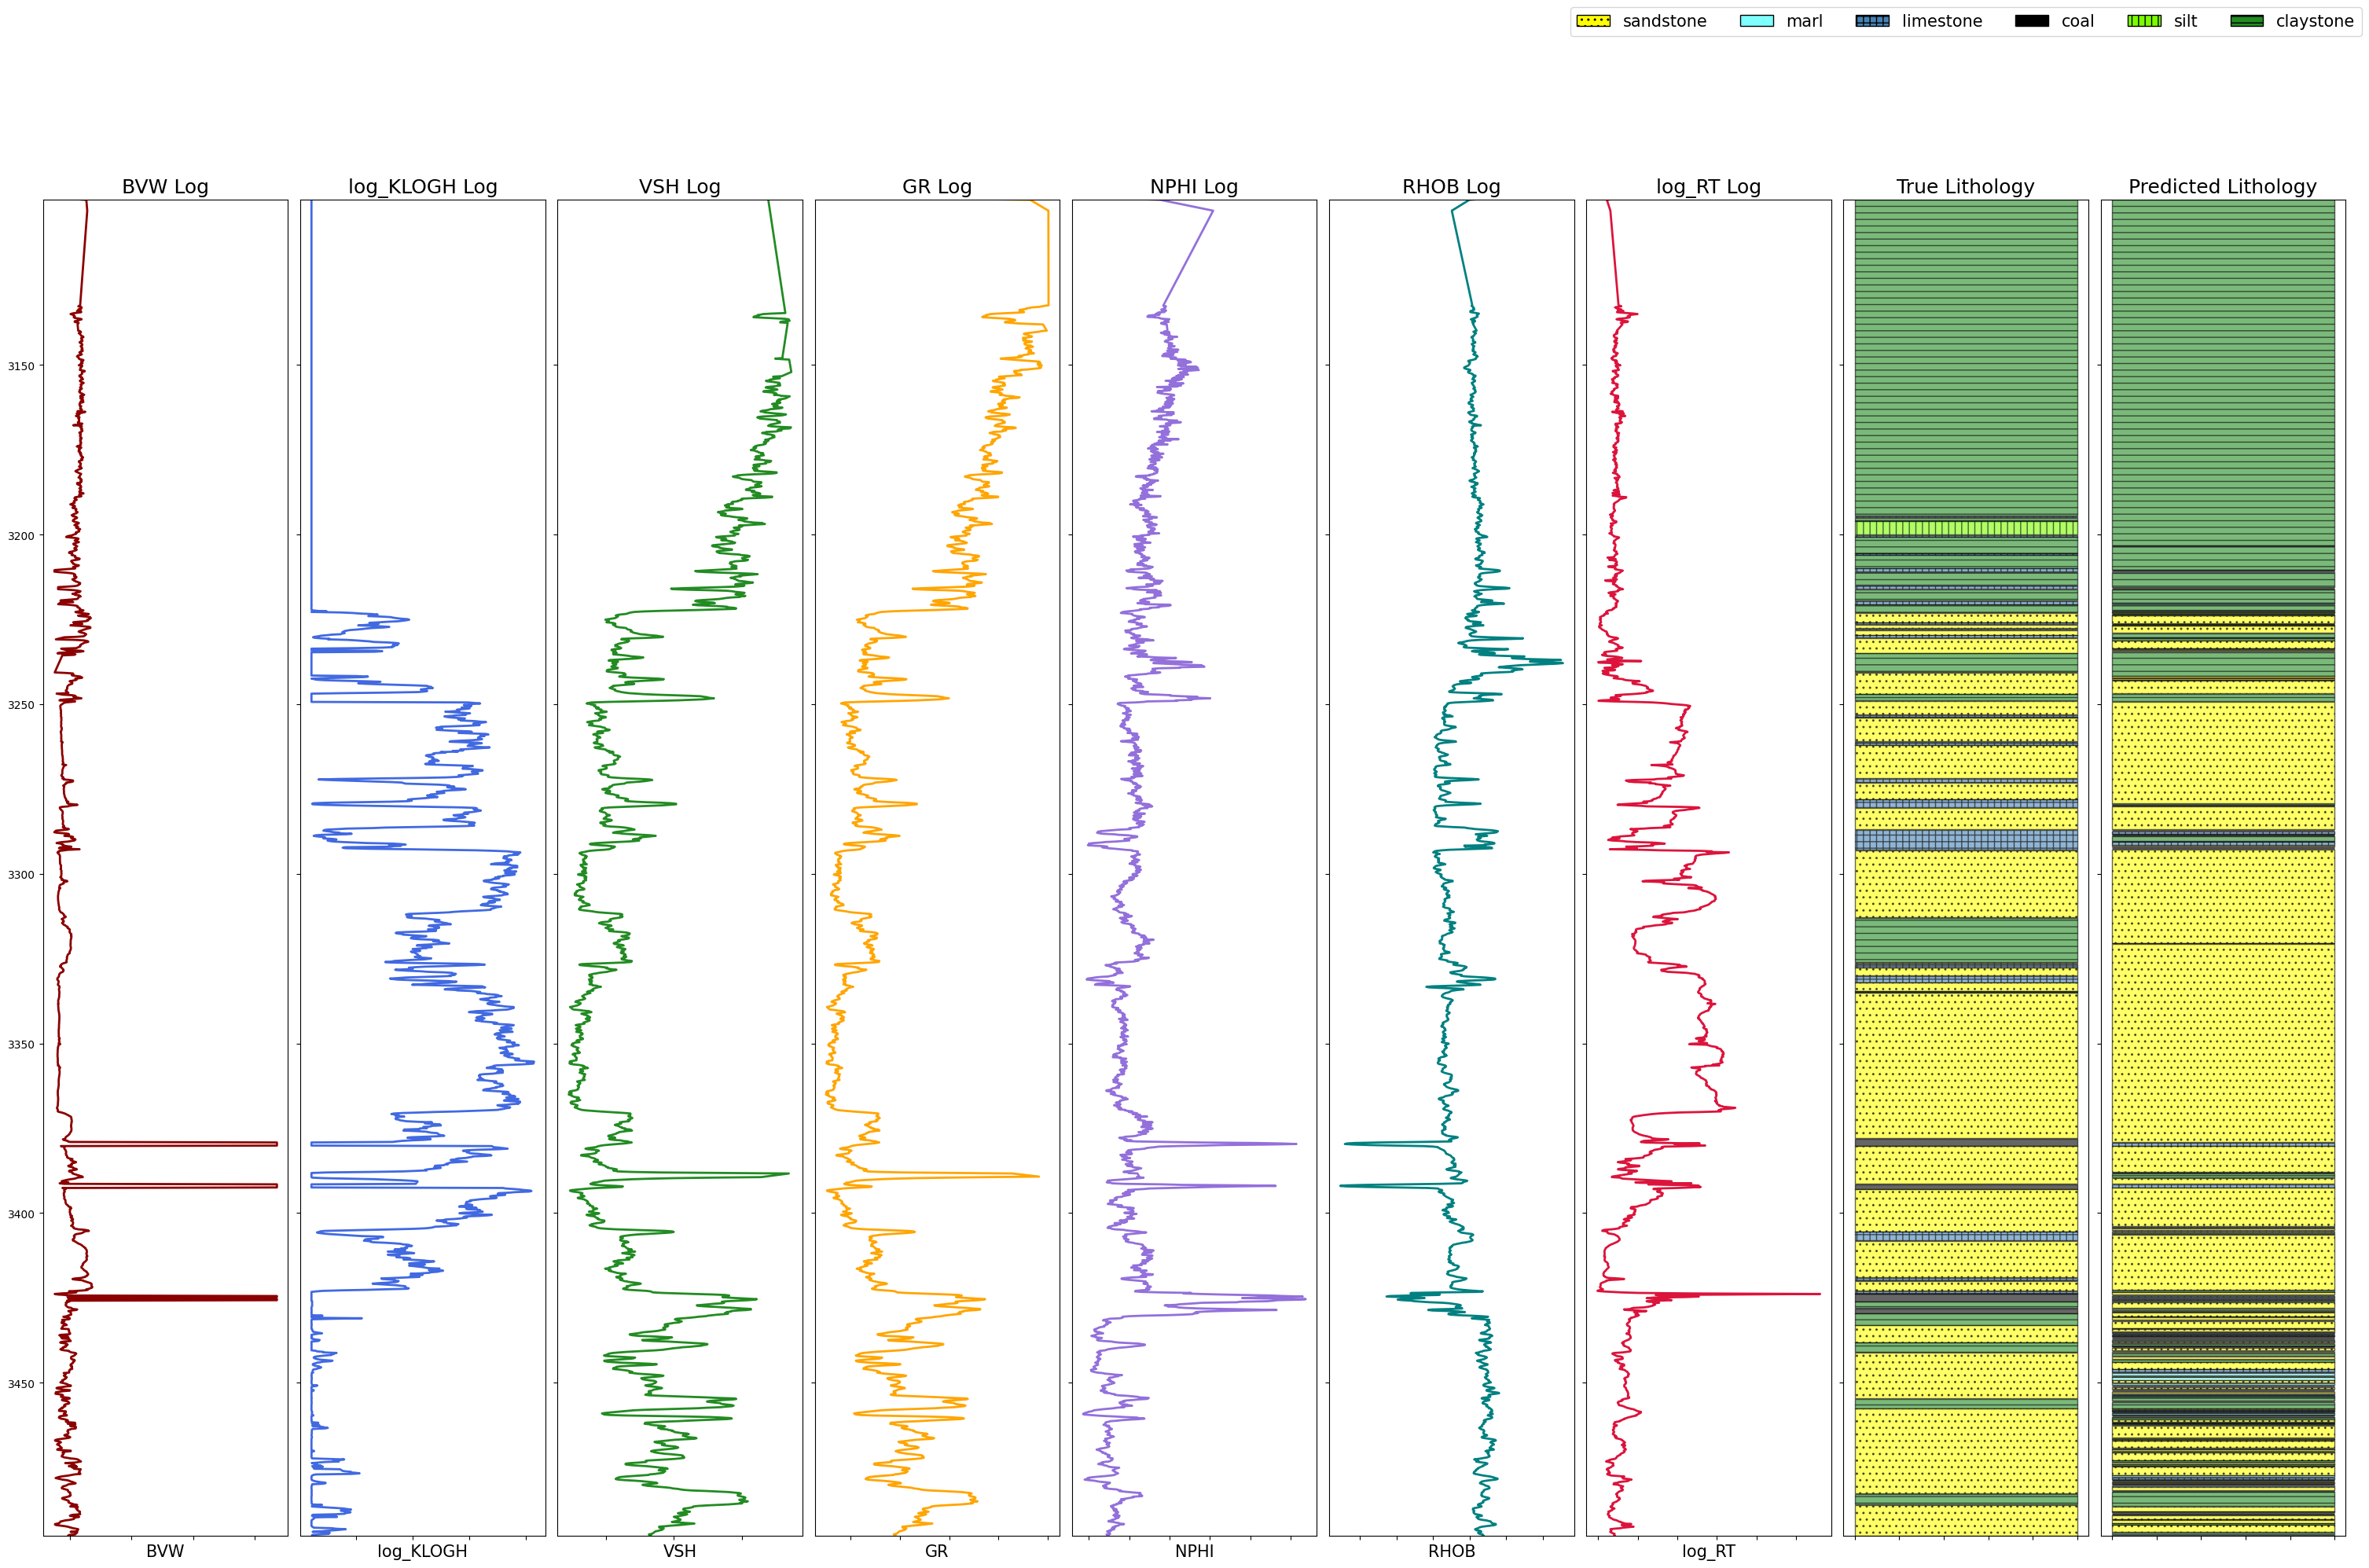

In [ ]:
KNNClassifier.plot_lithology_comparison(scaled_test_well_data[0], test_KNN_predicted_lithology, use_hatch=True, log_columns=feature_columns)

<p>We can also use the <code>plot_confusion_matrix()</code> function to evaluate the classification performance of the KNN model. This function generates a confusion matrix, which provides insights into how well the model distinguishes between different lithology classes. </p>

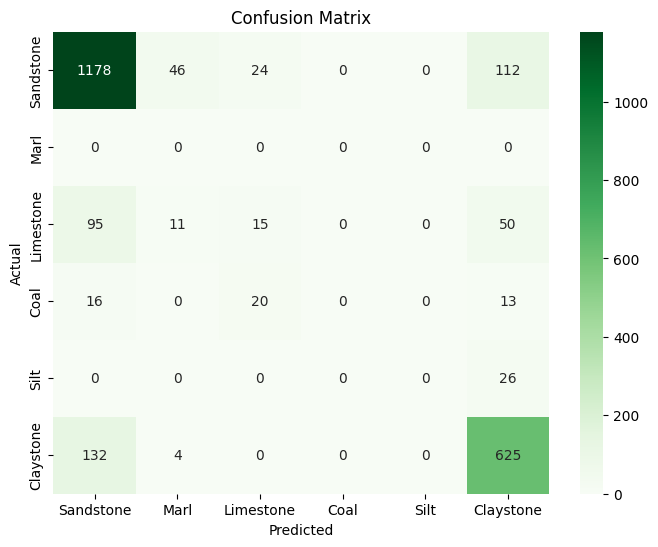

In [ ]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[0]['LITHOLOGY'].values, test_KNN_predicted_lithology, percentage=False) # you can also set percentage=True >> instead of counts, the values of the matrix are displayed as %

##### III$\,\,\,\,\,\,$Random Forest for Classification



Another commonly used classifier is Random Forest, an ensemble learning method that builds multiple decision trees and combines their outputs to improve classification accuracy.

In [ ]:
from Lib.ClassificationFunctions import RFClassification
RFClassifier = RFClassification()

<p>We define a dictionary of hyperparameters (`rf_params`) that control how the Random Forest is built and how complex the trees can become.</p>

In [ ]:
rf_params = {
    'n_estimators': 150,         # Number of trees in the forest
    'max_depth': 25,             # Maximum depth of each tree (limits tree growth) - how many levels of split can we see?
    'min_samples_split': 4,      # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,       # Minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',      # Number of features to consider when looking for the best split ('sqrt' = sqrt of total features)
    'bootstrap': True,           # Whether bootstrap samples are used when building trees (True enables sampling with replacement)
    'random_state': 42           # Seed used by the random number generator for reproducibility
}

Then we call a custom training function, `RFClassifier.train_random_forest()`, which:

Trains the Random Forest on the scaled training data

*   Trains the Random Forest on the scaled training data
*   Evaluates it on the validation data
*   Returns the trained model, the parameters used, the validation accuracy, and the predicted values

In [ ]:
trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.train_random_forest(scaled_train_well_data,
                                                                                                         scaled_val_well_data,
                                                                                                         feature_columns,
                                                                                                         target_column,
                                                                                                         rf_params,
                                                                                                         print_classification_report=True,
                                                                                                         print_classification_matrix=True)

Validation Accuracy: 0.7063

Classification Report:
               precision    recall  f1-score   support

   Claystone       0.07      0.91      0.13       342
        Coal       0.00      0.00      0.00       104
   Limestone       0.15      0.16      0.15       456
        Marl       0.82      0.69      0.75       579
   Sandstone       0.92      0.87      0.89     14915
        Silt       0.00      0.00      0.00      3032

    accuracy                           0.71     19428
   macro avg       0.33      0.44      0.32     19428
weighted avg       0.73      0.71      0.71     19428


Confusion Matrix:
 [[  311     0     0     8    23     0]
 [   16     0    14     0    74     0]
 [   56     0    71    70   259     0]
 [   37     3     6   399   134     0]
 [ 1634     0   336     4 12941     0]
 [ 2297     2    41     3   689     0]]


We can also run this in a loop, to test different values of the same hyperparameter. In the example below, we take a closer look at `n_estimators`.

n_estimator = 10
Validation Accuracy: 0.6894
n_estimator = 50
Validation Accuracy: 0.7101
n_estimator = 100
Validation Accuracy: 0.7092
n_estimator = 150
Validation Accuracy: 0.7063
n_estimator = 200
Validation Accuracy: 0.7073
n_estimator = 300
Validation Accuracy: 0.7122
n_estimator = 400
Validation Accuracy: 0.7135
n_estimator = 500
Validation Accuracy: 0.7137


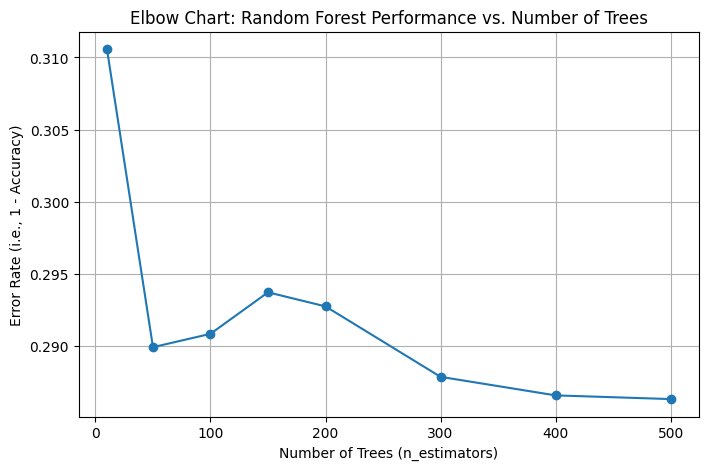

In [ ]:
import matplotlib.pyplot as plt

# Range of n_estimators to test
n_estimators_range = [10, 50, 100, 150, 200, 300, 400, 500]
rf_accuracies = []

# Loop through each number of trees
for n in n_estimators_range:
  print("n_estimator =", n)
  rf_params = {
        'n_estimators': n,
        'max_depth': 25,
        'min_samples_split': 4,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'bootstrap': True,
        'random_state': 42
        }

  trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.train_random_forest(
        scaled_train_well_data,
        scaled_val_well_data,
        feature_columns,
        target_column,
        rf_params
        )

  rf_accuracies.append(trained_RF_accuracy)

error_rates = [1 - acc for acc in rf_accuracies]

# Plot the elbow chart
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, error_rates, marker='o')
plt.title('Elbow Chart: Random Forest Performance vs. Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel("Error Rate (i.e., 1 - Accuracy)")
plt.grid(True)
plt.show()

In [ ]:
rf_params = {
    'n_estimators': 150,         # Number of trees in the forest
    'max_depth': 25,             # Maximum depth of each tree (limits tree growth) - how many levels of split can we see?
    'min_samples_split': 4,      # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,       # Minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',      # Number of features to consider when looking for the best split ('sqrt' = sqrt of total features)
    'bootstrap': True,           # Whether bootstrap samples are used when building trees (True enables sampling with replacement)
    'random_state': 42           # Seed used by the random number generator for reproducibility
}

trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.train_random_forest(scaled_train_well_data,
                                                                                                         scaled_val_well_data,
                                                                                                         feature_columns,
                                                                                                         target_column,
                                                                                                         rf_params,
                                                                                                         print_classification_report=False,
                                                                                                         print_classification_matrix=False)

Validation Accuracy: 0.7063


<p>After training, we evaluate the model on the test dataset using the <code>test_random_forest</code> function. The trained Random Forest classifier predicts lithology classes, which we can later compare to actual lithology labels. This step helps us understand how well the model generalises to new data.</p>

In [ ]:
accuracy_test_RF, test_RF_predicted_lithology = RFClassifier.test_random_forest(trained_RF, scaled_test_well_data[0], feature_columns, target_column)

Test Accuracy: 0.8090
Confusion Matrix:
 [[ 624    0    0    1  136    0]
 [   5    0   13    0   31    0]
 [  32    0    8    0  131    0]
 [   0    0    0    0    0    0]
 [  54    0   23    0 1283    0]
 [  26    0    0    0    0    0]]


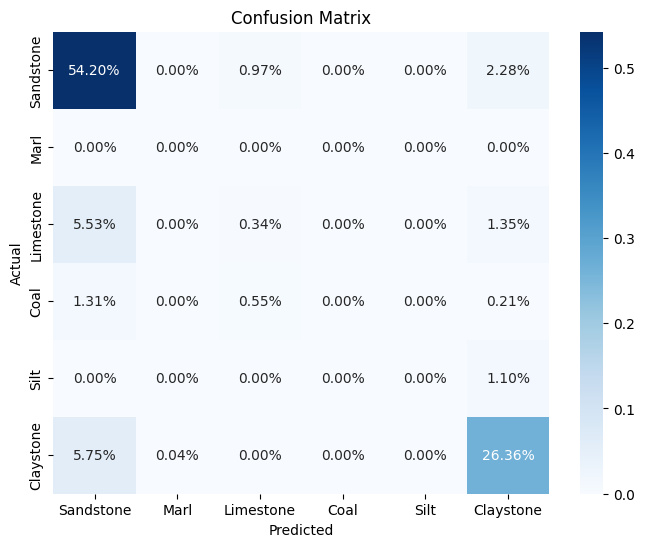

In [ ]:
KNNClassifier.plot_confusion_matrix(scaled_test_well_data[0]['LITHOLOGY'].values, test_RF_predicted_lithology, percentage=True)

<p>Similar to the earlier section, we can also use the <code>plot_lithology_comparison</code> function to visually compare the predicted lithology labels from the trained Random Forest model with the actual lithology labels in the test dataset.</p>

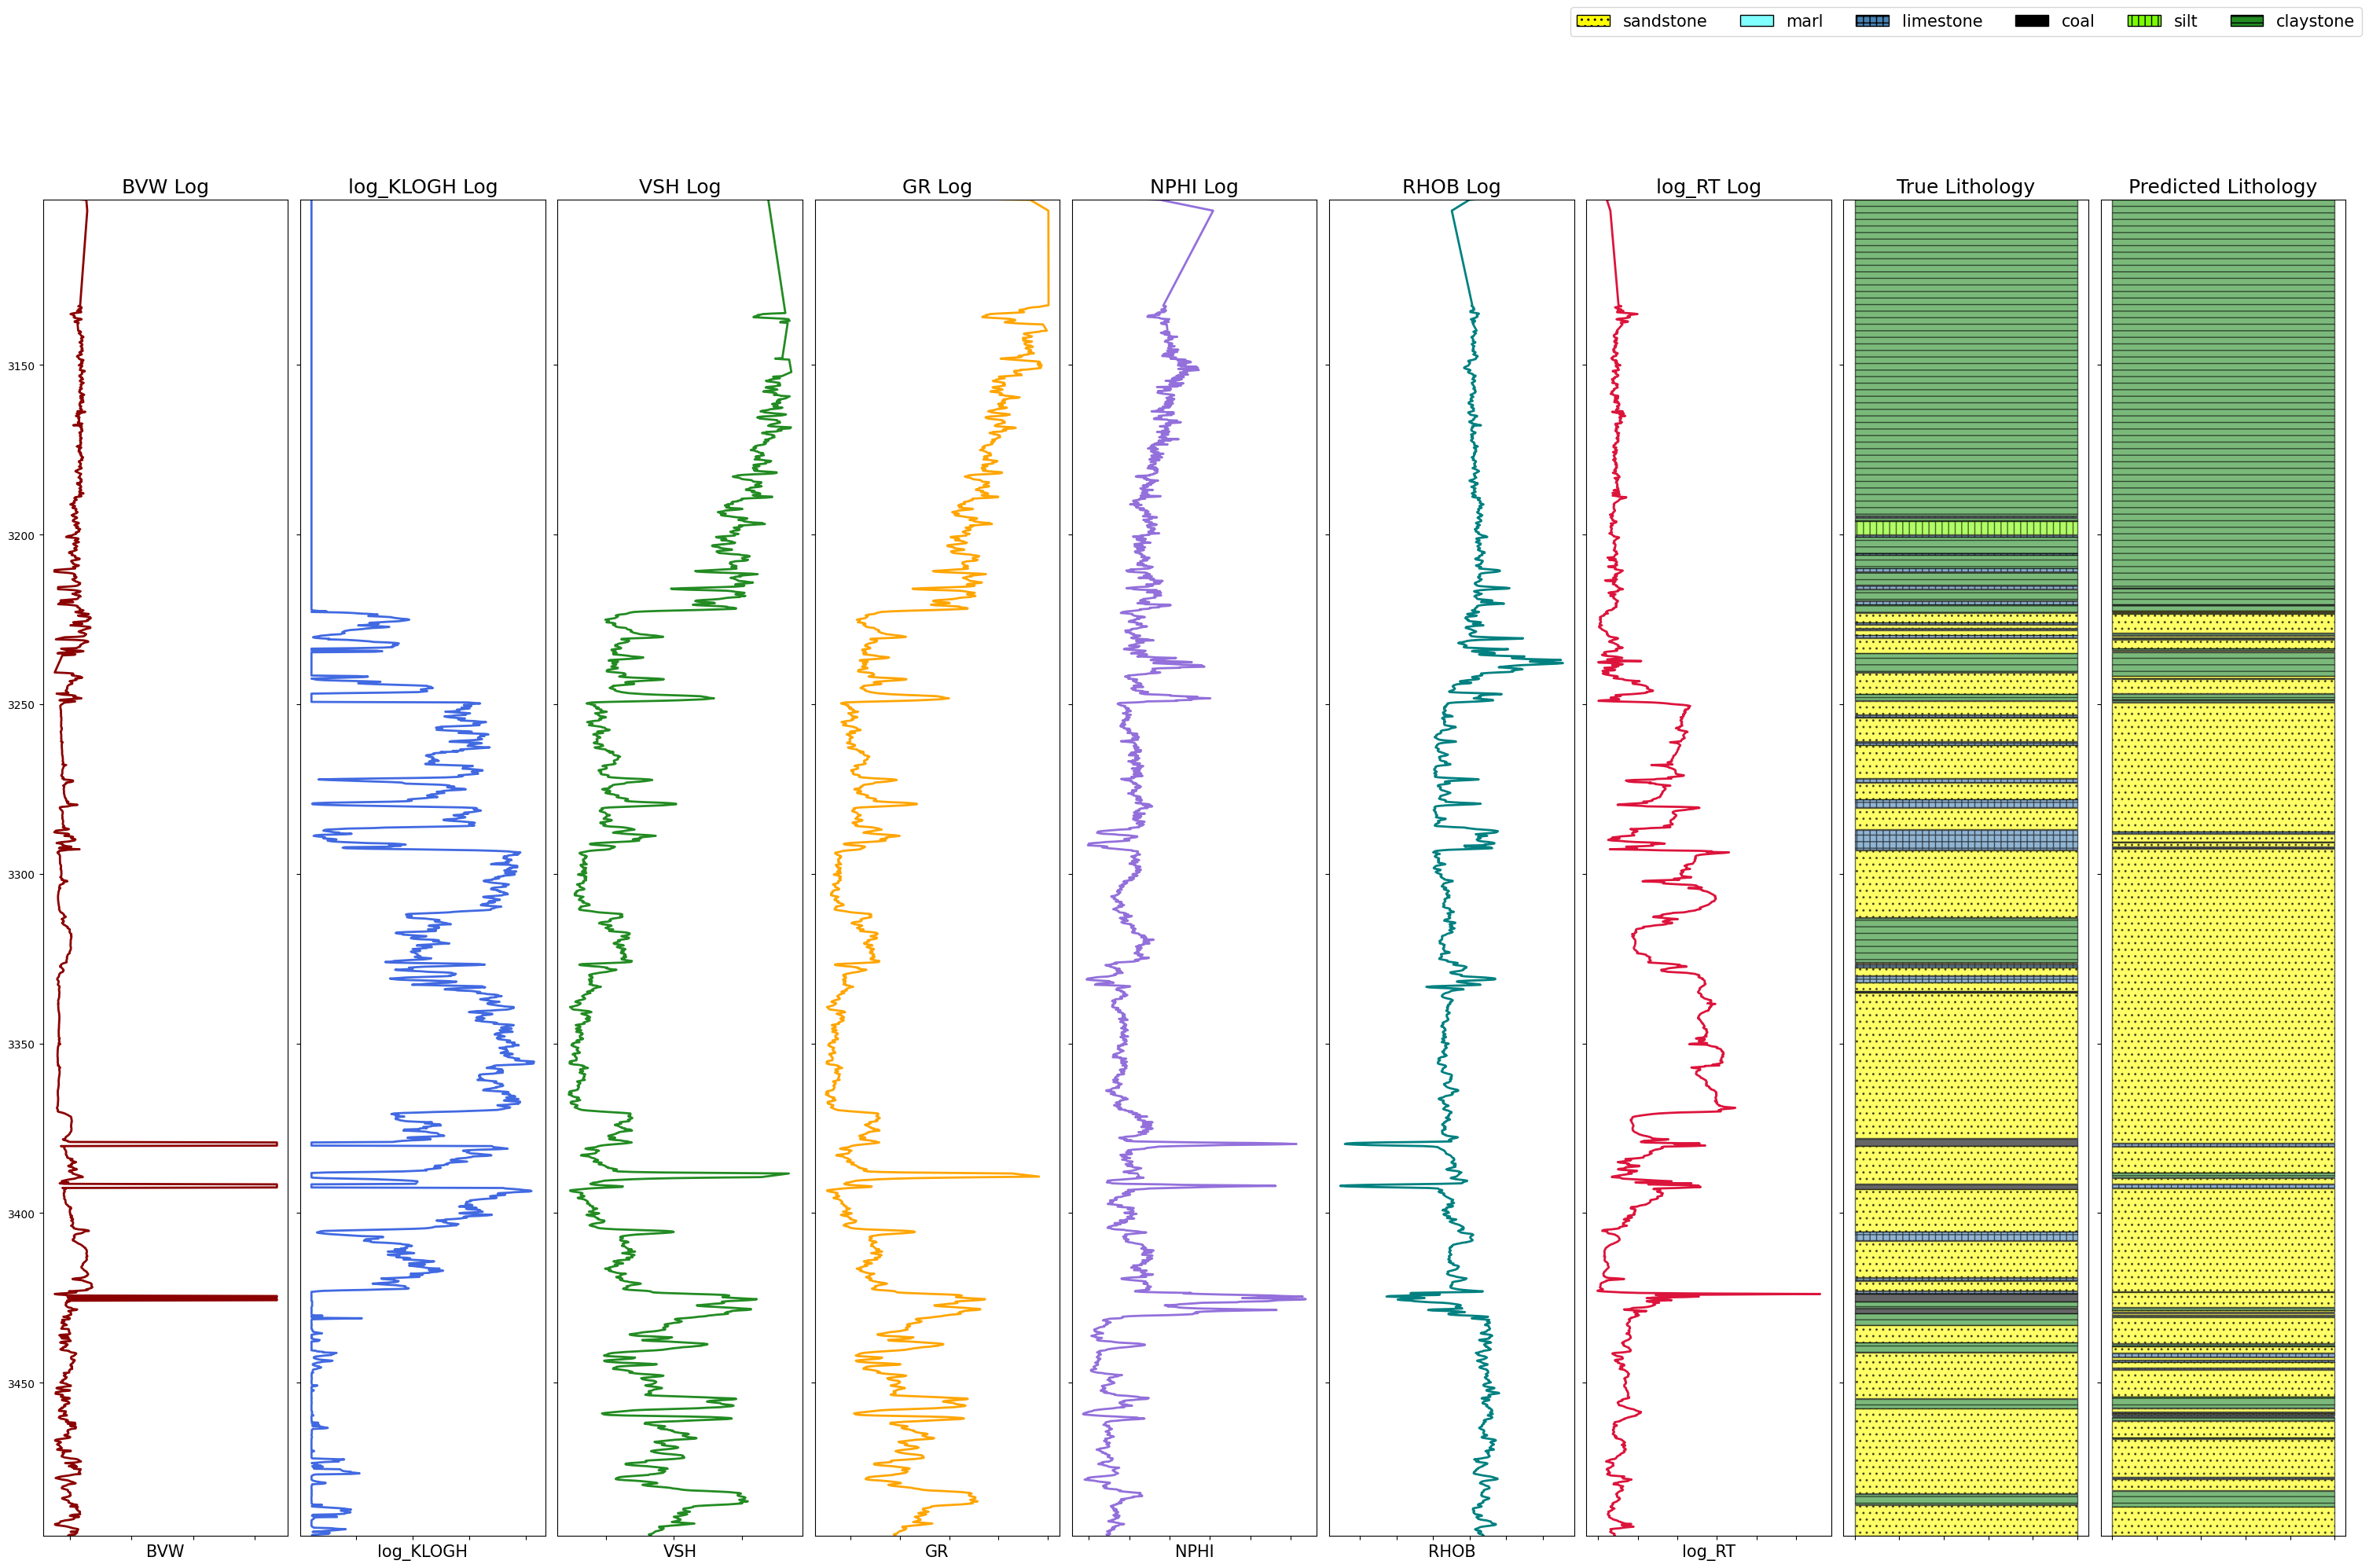

In [ ]:
KNNClassifier.plot_lithology_comparison(scaled_test_well_data[0], test_RF_predicted_lithology, use_hatch=True, log_columns=feature_columns)